# 7章 アンサンブル学習

様々な分類器を一つのメタ分類器として組み合わせる（= 複数の異なるモデルを組み合わせて精度を上げる）
- Voting: 多数決による予測
- Bagging: 抽出したデータセットから複数個の弱学習器の作成
- Boosting: 弱学習器の誤答を学習する弱学習器を作成


$$
\hat{y} = \text{mode} \left\{ C_1(x), C_2(x), \dots, C_m(x) \right\}
$$

$\text{mode}$ は最頻値を表す。アンサンブル法は、分類器を単体で使用した場合よりも効果が期待できる。

In [14]:
from scipy.special import comb
import math 

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2))
    probs = [comb(n_classifier, k) * error**k * (1 - error)**(n_classifier - k) for k in range(k_start, n_classifier + 1)]
    return sum(probs)

ensemble_error(11, error=0.25)

0.03432750701904297

### どれくらい精度が上がるのか

組み合わせる学習器が独立かつご識別率 $\epsilon$ がすべて同じ場合

$$
\epsilon_{\text{ensemble}} = \sum^n_k {}_n C_k \epsilon^k (1-\epsilon)^{n-k}
$$

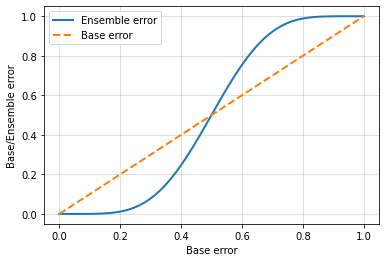

In [17]:
import numpy as np 
import matplotlib.pyplot as plt 

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()


## 7.2 多数決による分類器の結合

### 重み付きの多数決の数学表現

$$
\hat{y} = \text{arg} \max_i \sum^m_{j=1} w_j \chi_A (C_j(x) = i)
$$

### 予測されたクラスの確率を用いた多数決方法

$$
\hat{y} = \text{arg} \max_i \sum^m_{j=1} w_j p_{ij}
$$

In [10]:
# Load data
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data = load_iris()
X, y = data.data[50:, [1, 2]], data.target[50:]

## Label encofing
le = LabelEncoder()
y = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=1)

In [73]:
# Prepare classifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

clf_1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1)
clf_2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf_3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipeline_1 = Pipeline([('sc', StandardScaler()), ('clf', clf_1)])
pipeline_2 = Pipeline([('clf', clf_2)])
pipeline_3 = Pipeline([('sc', StandardScaler()), ('clf', clf_3)])

clf_labels = ['Logistic regression', 'Decision tree', 'kNN', 'Voting']

vote_clf = VotingClassifier(estimators=[pipeline_1, pipeline_2, pipeline_3])
scores = cross_val_score(estimator=vote_clf, X= X_train, y=y_train, cv=10, scoring='roc_auc')


/Users/s12723/ghq/github.com/yahooshiken/rinko/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/s12723/ghq/github.com/yahooshiken/rinko/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/s12723/ghq/github.com/yahooshiken/rinko/.venv/lib/python3.9/site-packages/sklearn/ensemble/_voting.py", line 292, in fit
    return super().fit(X, transformed_y, sample_weight)
  File "/Users/s12723/ghq/github.com/yahooshiken/rinko/.venv/lib/python3.9/site-packages/sklearn/ensemble/_voting.py", line 66, in fit
    names, clfs = self._validate_estimators()
  File "/Users/s12723/ghq/github.com/yahooshiken/rinko/.venv/lib/python3.9/site-packages/sklearn/ensemble/_base.py", line 225, in

In [72]:
from sklearn.model_selection import cross_val_score

print('10-fold cross validation: \n')
for clf, label in zip([pipeline_1, pipeline_2, pipeline_3, vote_clf], clf_labels):
    scores = cross_val_score(estimator=clf, X= X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: {:.4f} +/- {:.4f} [{}]'.format(scores.mean(), scores.std(), label))

10-fold cross validation: 

ROC AUC: 0.9167 +/- 0.1537 [Logistic regression]
ROC AUC: 0.8667 +/- 0.1833 [Decision tree]
ROC AUC: 0.8500 +/- 0.1333 [kNN]
ROC AUC: nan +/- nan [Voting]
/Users/s12723/ghq/github.com/yahooshiken/rinko/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/s12723/ghq/github.com/yahooshiken/rinko/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/s12723/ghq/github.com/yahooshiken/rinko/.venv/lib/python3.9/site-packages/sklearn/ensemble/_voting.py", line 292, in fit
    return super().fit(X, transformed_y, sample_weight)
  File "/Users/s12723/ghq/github.com/yahooshiken/rinko/.venv/lib/python3.9/site-packages/sklearn/ensemble/_voting.py", line 66,

## 7.5 アダブーストによる弱学習器の活用

弱学習器：当て推量を少し上回る程度の性能
分類の難しい訓練データに対して、Boostingを用いる。
代表的な

基本的なBoosting の仕組み
1. 弱学習器を訓練する
2. 誤分類した半分を使って弱学習器を訓練する
3. 結果が異なるデータを使って弱学習機を訓練する
4. 多数決により組み合わせる

- ノイズや異常値の影響を受けやすい

アダブーストの仕組み
- 訓練データセット全体を使って弱学習器を訓練
- イテレーションのたびに重み付けを更新する。


In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)

In [4]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
x_test_pred = tree.predict(X_test)





NameError: name 'X_train' is not defined